<div align="center">

---
# ML1 | AdaBoost Classifier 
Analysis & Optimization
-
---
</div>

<div align = "center">

--- 
## Project Overview
---
</div>

In recent years, the rise of Artificial Intelligence and the widespread use of Machine Learning have revolutionized the way we tackle complex real-world challenges. However, due to the diverse nature of data involved, choosing the right algorithm is crucial to achieve efficient and effective solutions. Therefore, understanding the strengths and weaknesses behind different Machine Learning algorithms, and knowing how to adapt them to meet specific challenges, can become a fulcral skill to develop.

Furthermore, since the choice of algorithm greatly depends on the specific task and data involved, it's clear that there is no "Master Algorithm" (No algorithm can solve every problem). For example, while Linear Discriminants effectively delineate boundaries in data that is linearly separable, they struggle to capture relationships in more complex, higher-dimensional spaces.

This Project focuses on the following topic:

<div align="center">
    
> With no Master Algorithm, is it possible to improve a existing Machine Learning Algorithm in characteristics it struggles the most?
</div>

Therefore, after choosing a Machine Learning algorithm and gaining a thorough understanding of its theoretical and empirical aspects, we aim to refine it, specifically targeting its weaknesses in solving classification problems.

<div align = "center">

--- 
## Classifier Selection
---
</div>

Nowadays, since some Machine Learning Algorithms can fall short to predict the whole data given, we decided to study an Ensemble Algorithm. Since these Algorithms can combine outputs of multiple models it makes them more prone to better address more complex problems and therefore provide better solutions. Consequently this new types of algorithms tend to have a better performance which contributes for a overall better algorithm.

Additionally, after careful consideration, we decided to focus on enhancing the AdaBoost Algorithm M1, which is employed in binary classification problems.

<center><img src="./Assets/Boosting.gif" width="500" title="Boosting"></center>

<div align = "center">

--- 
## AdaBoost Overview
---
</div>

**AdaBoost** (Adaptive Boosting) is a type of ensemble learning technique used in machine learning to solve both **classification** and **regression** problems. It consists on training a series of weak classifiers on the dataset. Therefore, with each iteration, the algorithm **increases the focus** on data points that were **previously predicted incorrectly**.

As a result, the AdaBoost algorithm builds a model by considering all the individual **weak classifiers** which are **weighted based on their performance**. Consequently, classifiers with **higher predictive accuracy contribute more to the final decision** which **reduces the influence of less accurate ones** in the final prediction. 

Finally, here's the **pseudocode** behind the AdaBoost M1 Algorithm used in this Notebook:

<div align = "center">

--- 
### AdaBoost.M1 [Pseudocode]
---
</div>

1. Initialize the observation weights $w_i = \frac{1}{N}$, for $i = 1, 2, \dots, N$.

2. For $ m = 1 $ to $ M $:
   \
   a) Fit a classifier $ G_m(x) $ to the training data using weights $ w_i $
   \
   b) Compute
      $$
      \text{err}_m = \frac{ \sum_{i=1}^N w_i I(y_i \neq G_m(x_i)) }{ \sum_{i=1}^N w_i }
      $$
   c) Compute $ \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right) $
   \
   \
   d) Set $ w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq G_m(x_i))\right) $, for $ i = 1, 2, \dots, N $.

4. Output $ G(x) = \text{sign}\left( \sum_{m=1}^M \alpha_m G_m(x) \right) $.


> **Source**: *The Elements of Statistical Learning, ch. 10*

<div align = "center">

--- 
### AdaBoost.M1 [Step Guide]
---
</div>

As previously discussed, AdaBoost techniques combine many weak machine-learning models to create a **powerful classification model** for the output which envolves the following steps:

1. **Initialize the Weights**
    - For a dataset with $N$ training data points instances, initialize $N W_{i}$ weights for each data point with $W_{i} = \frac{1}{N}$

<p></p>

2. **Train Weak Classifiers**
    - Train a weak classifier $M_k$ where $k$ is the current iteration
    - The weak classifier we are training should have an accuracy greater than 0.5 which means it should be performing better than a naive guess

<p></p>

3. Calculate the **Error Rate** and **importance of each weak model $M_k$**
    - Calculate rate $error\_rate$ for every weak classifier $M_k$ on the training dataset
    - Calculate the importance of each model $α\_k$ using formula $\alpha_k = \frac{1}{2} \ln{\frac{1 – error_k}{error_k}}$

<p></p>

4. **Update** data point **weight** for each data point $W_i$:
    - After applying the weak classifier model to the training data we will update the weight assigned to the points using the accuracy of the model. The formula for updating the weights will be $w_i = w_i \exp{(-\alpha_k y_i M_k(x_i))}$. Here $y_i$ is the true output and $X_i$ is the corresponding input vector

<p></p>

5. **Normalize the Instance weight**
    - We will normalize the instance weight so that they can be summed up to 1 using the formula $W_i = W_i / sum(W)$

<p></p>

6. **Repeat steps 2-5 for $K \space iterations$**
    - We will train $K \space classifiers$ and will calculate model importance and update the instance weights using the above formula
    - The final model $M(X)$ will be an ensemble model which is obtained by combining these weak models weighted by their model weights

Theoretically the **AdaBoost Algorithm** can use any Machine Learning algorithm as **Weak Learners**. However, depending on the **problem and data** at hand, the final model might require a **more delicate** approach on it's **evaluation**. Therefore the **best** algorithms to use as **weak learners** are typically those that are **fast**, **simple** and slightly **better than random guess** which is why we started developing AdaBoost with **Stumps** (Decision Trees of Depth 1). 

<div align = "center">

--- 
### AdaBoost.M1 [Disadvantages]
---
</div>

Despite the Algorithms powerfull techinques, it yet remains limited by a few factors.

#### Noisy Data and Outliers

For instance, if the AdaBoost algorithm is used upon noisy data, it can focus too much on correcting previous misclassifications despite their actual trends, which can lead to overfitting. Moreover, outliers can also impact the algorithm's performance significantly. Since AdaBoost tries to perfectly fit each example, it can overlook on rare instances in the data rather than finding the actual patterns within it.

#### Choice of Weak Learner

Furthermore, AdaBoost can be quite sensitive to the Weak Learners used. As previously mentioned, the best weak models are often described as simple, fast and with low variance. Therefore, they do not memorize the training data but rather learn to generalize different aspects within the data.

#### Computational Cost

Since AdaBoost consists of a Boosting Algorithm, it's performance mainly depends on the amount of boosting rounds performed during training. This main hyperparameter can easily affect the model's effectiveness which can lead to overfitting as well as to high computational costs.

<div align = "center">

--- 
## Importing Dependencies
---
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Project's Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, KFold, cross_val_score)
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score)
from sklearn.utils import (shuffle)
from sklearn.datasets import (make_classification)
from sklearn.ensemble import (AdaBoostClassifier)
import scikit_posthocs as sp
from scipy.stats import (friedmanchisquare)
import openml

from AdaBoostStudy.AdaBoost import (AdaBoost)
from AdaBoostStudy.DataPreprocessing import (Fetch_Dataset, Fetch_X_y)
from AdaBoostStudy.ModifiedAdaBoost import (AdaBoostTunedDT, AdaBoostPerceptron, AdaBoost_Outliers)
from AdaBoostStudy.ModelEvaluation import (Save_json_file, Load_json_file, Manage_Results, Perform_KFold_CV, Perform_Mean_KFold_CV, Evaluate_Model, Evaluate_Models)
from AdaBoostStudy.DataVisualization import (Plot_Scatterplot, Plot_Scatterplots, Compare_Models_Accuracies, Display_Confusion_Matrix, Plot_ROC_Curve, Plot_Weak_Learners_Stats, Plot_Model_Stats, Compare_Models_Stats, Model_Accuracies_Per_Dataset, Plot_Critial_Difference_Diagram)

<div align = "center">

--- 
## Data Preprocessing [Datasets Selection]
---
</div>

Since the developed AdaBoost Algorithm focuses on Binary Classification Problems, we decided to filter all the datasets inside the `OpenML-CC18 Curated Classification` study. Therefore, by selecting those with 2 possible target values we will can ensure a proper training of our Models.

In [3]:
# List all tasks in the 'OpenML-CC18' benchmark
benchmark = openml.study.get_suite('OpenML-CC18')
df_tasks = openml.tasks.list_tasks(output_format="dataframe", task_id=benchmark.tasks)
df_tasks.head()

,tid,ttid,did,name,task_type,status,estimation_procedure,source_data,target_feature,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
3,3,TaskType.SUPERVISED_CLASSIFICATION,3,kr-vs-kp,Supervised Classification,active,10-fold Crossvalidation,3,class,1669,3.0,1527,2,37,3196,0,0,0,37
6,6,TaskType.SUPERVISED_CLASSIFICATION,6,letter,Supervised Classification,active,10-fold Crossvalidation,6,class,813,26.0,734,26,17,20000,0,0,16,1
11,11,TaskType.SUPERVISED_CLASSIFICATION,11,balance-scale,Supervised Classification,active,10-fold Crossvalidation,11,class,288,3.0,49,3,5,625,0,0,4,1
12,12,TaskType.SUPERVISED_CLASSIFICATION,12,mfeat-factors,Supervised Classification,active,10-fold Crossvalidation,12,class,200,10.0,200,10,217,2000,0,0,216,1
14,14,TaskType.SUPERVISED_CLASSIFICATION,14,mfeat-fourier,Supervised Classification,active,10-fold Crossvalidation,14,class,200,10.0,200,10,77,2000,0,0,76,1


In [4]:
# Creating a Dictionary to store each dataset's information
my_tasks = {}

for task_id in df_tasks.loc[df_tasks['NumberOfClasses'] == 2]['tid'].to_numpy():
    name, ds = Fetch_Dataset(task_id)
    
    target_values = list(np.unique(ds['target']))
    
    if (len(target_values) > 0 and task_id not in my_tasks.keys()):
        
        features = list(ds.columns[:-1])
        target = ds.columns[-1]
        
        content = {'Name':name,
                   'Features':features,
                   'Target':target,
                   'TargetValues':target_values}
        
        my_tasks.update({task_id: content})

In [5]:
# Display all the datasets selected
for task_id, info_task in my_tasks.items():
    name, ds = Fetch_Dataset(task_id)
    print(f"[Dataset ID {task_id}]: {info_task['Name']}\n")
    print(f"[Features]: {info_task['Features']}", '\n')
    print(f"[Target]: {info_task['Target']}", '\n')
    print(f"[Target Values]: {info_task['TargetValues']}", '\n')
    print('-'*30, '\n')

[Dataset ID 3]: kr-vs-kp

[Features]: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 15]: breast-w

[Features]: ['Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity', 'Marginal_Adhesion', 'Single_Epi_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 29]: credit-approval

[Features]: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 31]: credit-g

[Featur

<div align = "center">

--- 
## Base Model Evaluation
---
</div>

Initially we started by evaluating the Algorithm to obtain ground results that can be later used against further new modified versions. Therefore, by performing a K-Fold Cross Validation upon all the choosen datasets we were able to determine an estimate of the Model's overall Accuracy.


In [6]:
try:
    # Model Already Evaluated with the results Stored
    Base_Results = pd.read_csv('./Experimental Results/AdaBoost_Base_Results.csv')
except:
    # Evaluating the Base Model as well as the Sklearn's version
    Base_Results, _ = Evaluate_Models(my_tasks, [AdaBoost(), AdaBoostClassifier()], ['AdaBoost [Base]', 'AdaBoost [Sklearn]'])
    Base_Results.to_csv('./Experimental Results/AdaBoost_Base_Results.csv', index=False)

Base_Results

,Dataset,Positive Class (%),Negative Class (%),Majority Class (%),AdaBoost [Base],AdaBoost [Sklearn]
0,kr-vs-kp,0.477785,0.522215,0.522215,0.940859,0.964325
1,breast-w,0.349927,0.650073,0.650073,0.963418,0.956086
2,credit-approval,0.546708,0.453292,0.546708,0.872860,0.849877
3,credit-g,0.300000,0.700000,0.700000,0.758000,0.753000
4,diabetes,0.348958,0.651042,0.651042,0.769612,0.751354
5,spambase,0.394045,0.605955,0.605955,0.933927,0.940009
6,tic-tac-toe,0.653445,0.346555,0.653445,0.732755,0.773467
7,electricity,0.575455,0.424545,0.575455,0.770635,0.811728
8,pc4,0.122085,0.877915,0.877915,0.893019,0.901923
9,pc3,0.102367,0.897633,0.897633,0.895072,0.885476


As we can observe from the results obtained, we can infer that our AdaBoost Algorithm was well implemented since it's accuracies on the selected datasets do not differ significantly from the ones obtained by the Scikit-Learn's Version.

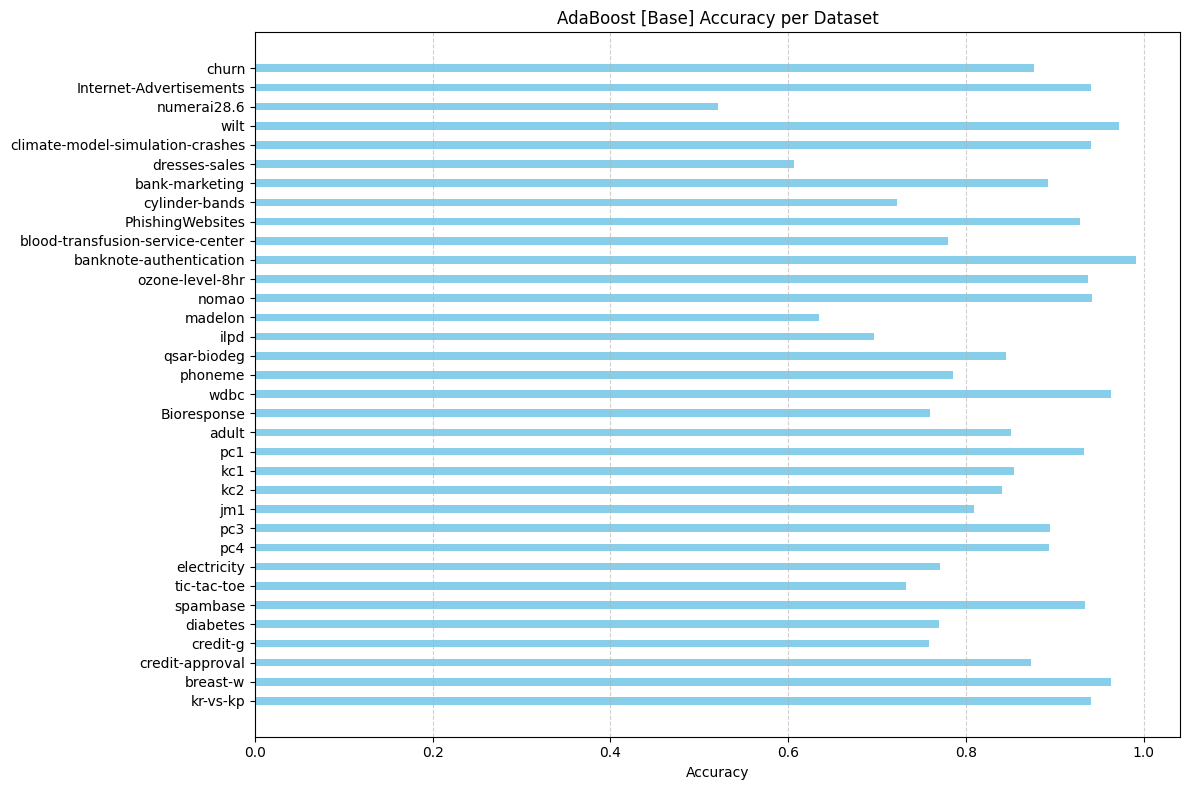

In [7]:
# Plotting the Base Reults of our algoritm's base implementation
Model_Accuracies_Per_Dataset(Base_Results, 'AdaBoost [Base]')

> This Barplot displays how the Algorithm performs against each selected dataset.

    Overall, the AdaBoost Algorithm seems to be performning quite well against most of the datasets.

Furthermore, in order to **dive deeper** on how the Algorithm **performs** we dicided to evaluate it against one of the selected datasets. We considered the `Breast-W Dataset` against the following concepts:

- **Weak Learner's Training Error**
  - Evaluating how the weak learner's **error evolves during training** can provide great insights on how they affect the overall algorithm.
- **Weak Learner's Weights**
  - The weights of each weak learner can help understand the **impact of each classifier on the final decision**.
- **Confusion Matrix**
  - Matrix that conveys the model's **classification results** (TP, TN, FP, FN).
- **ROC Curve**
  - Provides a great understanding of the **model's tradeoffs** between both **true positive and false positive rates**.
  - Alongside the ROC Cuve, the **AUC (Area Under Curve)** also helps quantify the model's classification **performance**.

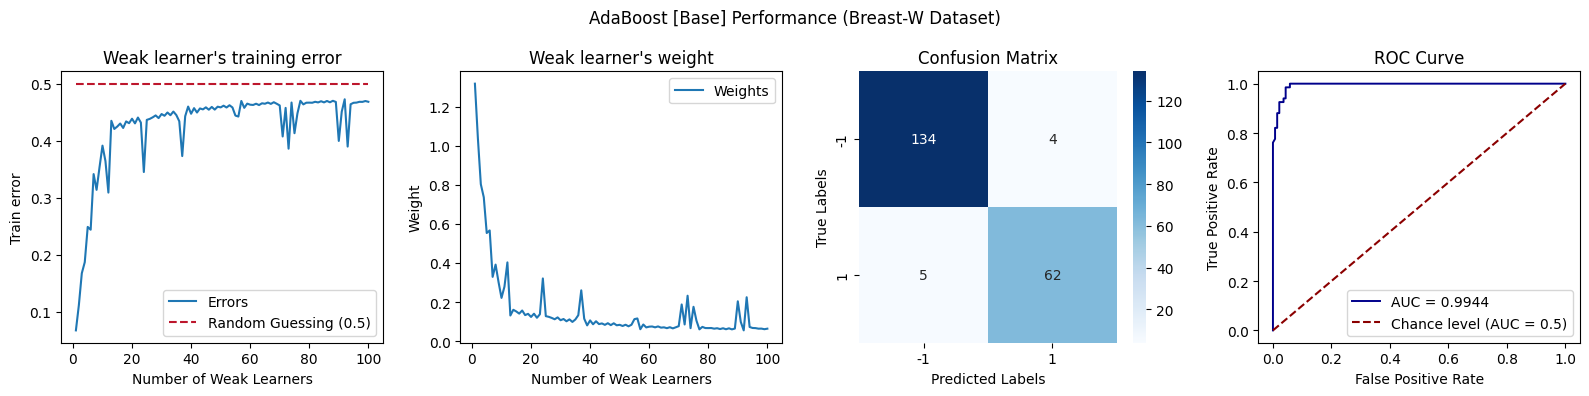

In [8]:
# Model Performance Evaluation on the Breast-W Dataset (Task ID 15)
name, X, y = Fetch_X_y(task_id=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ab = AdaBoost()
ab.fit(X_train, y_train)
Plot_Model_Stats(ab, X_test, y_test, "AdaBoost [Base] Performance (Breast-W Dataset)")

As we progress training new weak learners through other partitions of the data at each new boosting round, we visualize the decrease of their weights in the final decision as well as an increase of their training error. This happens due to the fact that the initial weak learners have much more "new" data to be processed which makes it more prune to find a better classification boundary and therefore have a higher "say" in the final prediction. As the rounding boosts happen the data the weak learners train with start to repeat over misclassified examples due to the fact that the AdaBoost Algorithm tends to enphasize the weak learner's training over previous misclassified data. Furthermore, if these data entries are in fact, outliers, then the algorithm is constantly forcing a proper training over misclassified examples that do not in fact improve the algorithm's ability to reconize patterns within the data, which can lead to it's overtfitting.

The algorithm behaves well against the data from the Breast-W dataset which can be easily infered through the Confusion Matrix (it correctly classifies most of the data) and through the ROC Curve (Due to the AUC being 0.994, we can conclude that the model performs really good against the dataset provided).

<div align = "center">

--- 
## AdaBoost.M1 [Improvements]
---
</div>

<div align = "center">

In this Section we focus on tempering with the algorithm's disadvantages in order to make it better. Therefore, by performing statistical inference upon the behaviour of the new modified models on the selected datasets, we are capable to compare the algorithm's improvement face the previous control results.

<div align="center">

--- 
### Choice of Weak Learners
---
</div>

After considering the disadvantages behind the Algorithm we came up with a few possible modifications that could tackle some of it's problems.

Firstly we started by assessing how the choice of Weak Learners could impact the Algorithm's Performance. As previously mentioned, weak learners should not only be capable of achieving performance levels that are slightly better than random guessing  but also remain simple enough so that they do not require high computational costs.

Therefore, we considered using:

- Decision Trees with Increased Depth
  - In AdaBoost decision stumps are commonly used since they are less prune to overfit. However, slightly deeper trees (Max Depth of 3 as used bellow) might be more beneficial to capture more complex patterns without causing significant overfitting.

- Perceptrons
  - Perceptrons are simple linear classifiers that compute a weighted sum of inputs to make decisions which leads to faster training times compared to decision trees.
  - For datasets with linearly separable data, perceptrons often converge quickly to a good solution making them very effective.
  - Due to their simplicity, Perceptrons can prevent the Model from becoming too complex. This simplicity can be advantageous in imbalanced datasets where complex models might overfit by learning too much from the minority class examples (Noise and Outliers).

In [9]:
# Calcular as Accuracies para cada Weak Learner em cada dataset
# Calcular a qtd de weak learners que teve uma accuracy pior do que a calculada - fazer um gráfico (x - # Weak Learners that have a lower accuracie than the obtained by the overall model) 
                                                                                                # (y - delta of both model's performance for each dataset)

# Maybe Replace the Perceptron as a Multi-Layered one with 1 or 2 hidden layers to analyse if the performance has improved or not

In [10]:
WEAK_LEARNERS_FILE = './Experimental Results/AdaBoost_Weak_Learner_Modifications_Results'
try:
    Weak_Learner_Modifications_Results_df = pd.read_csv(WEAK_LEARNERS_FILE + '.csv')
    Weak_Learner_Modifications_Results = Load_json_file(WEAK_LEARNERS_FILE + '.json')
except:
    models = [AdaBoost(), AdaBoostTunedDT({'max_depth':3}), AdaBoostPerceptron()]
    (Weak_Learner_Modifications_Results_df,
     Weak_Learner_Modifications_Results) = Evaluate_Models(my_tasks, models, ['AdaBoost [Base]', 'AdaBoost [DT - MaxDepth 3]', 'AdaBoost [Perceptron]'])
    
    Weak_Learner_Modifications_Results_df.to_csv(WEAK_LEARNERS_FILE + '.csv', index=False)
    Save_json_file(Weak_Learner_Modifications_Results, WEAK_LEARNERS_FILE + '.json')

Weak_Learner_Modifications_Results_df

,Dataset,Positive Class (%),Negative Class (%),Majority Class (%),AdaBoost [Base],AdaBoost [DT - MaxDepth 3],AdaBoost [Perceptron]
0,kr-vs-kp,0.477785,0.522215,0.522215,0.940859,0.987169,0.966204
1,breast-w,0.349927,0.650073,0.650073,0.963418,0.969257,0.963386
2,credit-approval,0.546708,0.453292,0.546708,0.872860,0.874422,0.685966
3,credit-g,0.300000,0.700000,0.700000,0.758000,0.769000,0.700000
4,diabetes,0.348958,0.651042,0.651042,0.769612,0.759121,0.664112
5,spambase,0.394045,0.605955,0.605955,0.933927,0.945226,0.855681
6,tic-tac-toe,0.653445,0.346555,0.653445,0.732755,0.986420,0.670152
7,electricity,0.575455,0.424545,0.575455,0.770635,0.814972,0.720604
8,pc4,0.122085,0.877915,0.877915,0.893019,0.901928,0.862825
9,pc3,0.102367,0.897633,0.897633,0.895072,0.881005,0.873974


In [13]:
# Managing and PLotting Results
# results = Manage_Results(Weak_Learner_Modifications_Results)
# for idx, result in enumerate(results):
#     Plot_Scatterplot(result, f"{Weak_Learner_Modifications_Results_df.columns[idx+5]} Analysis", f"$\Delta$ Accuracy", '# Weak Learners with Less Accuracy')

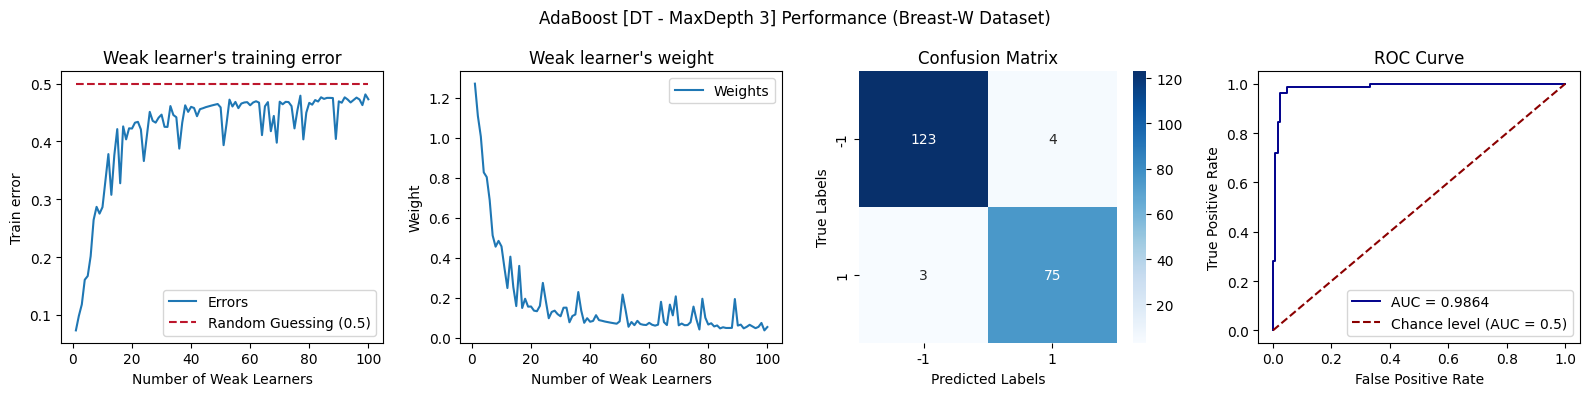

In [29]:
# Model Performance Evaluation on the Breast-W Dataset (Task ID 15)
name, X, y = Fetch_X_y(task_id=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ab = AdaBoostTunedDT()
ab.fit(X_train, y_train)
Plot_Model_Stats(ab, X_test, y_test, "AdaBoost [DT - MaxDepth 3] Performance (Breast-W Dataset)")

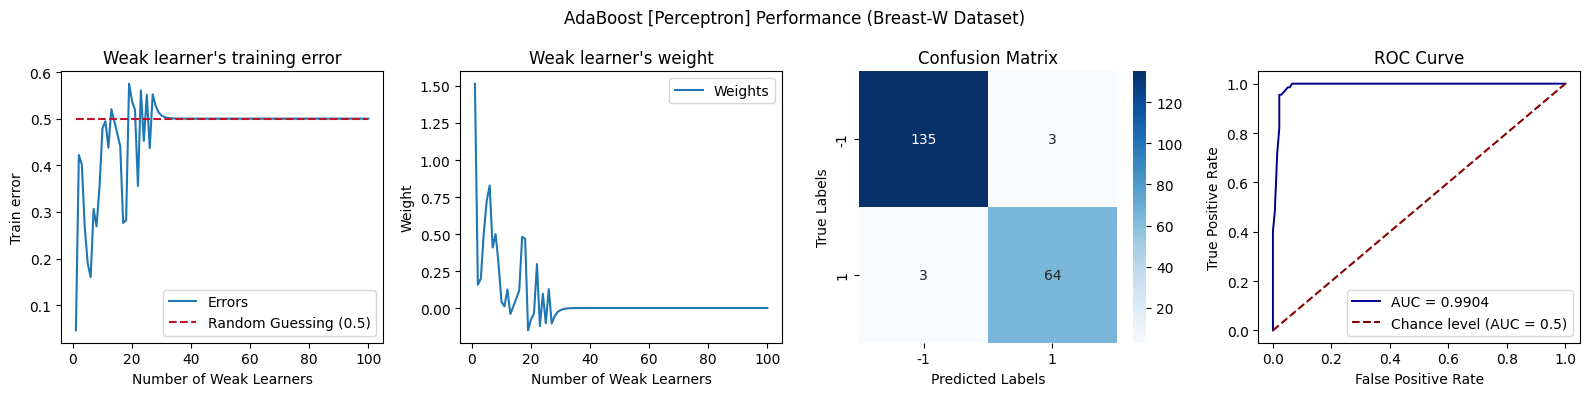

In [30]:
# Model Performance Evaluation on the Breast-W Dataset (Task ID 15)
name, X, y = Fetch_X_y(task_id=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ab = AdaBoostPerceptron()
ab.fit(X_train, y_train)
Plot_Model_Stats(ab, X_test, y_test, "AdaBoost [Perceptron] Performance (Breast-W Dataset)")

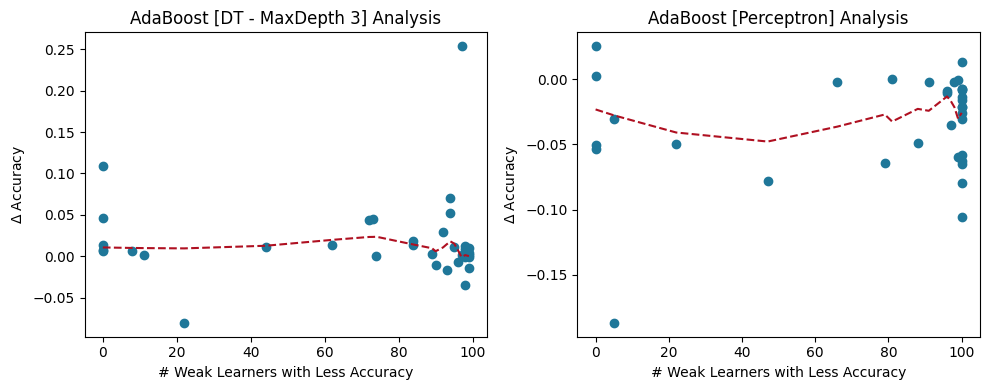

In [27]:
# Analysing the Weak Learners Performance for each new version of AdaBoost
results = Manage_Results(Weak_Learner_Modifications_Results)
Titles = [f"{Weak_Learner_Modifications_Results_df.columns[idx+4+i]} Analysis" for i in range(len(Weak_Learner_Modifications_Results_df.columns)-5)]
Plot_Scatterplots(results, Titles, f"$\Delta$ Accuracy", '# Weak Learners with Less Accuracy')

### FriedMan Test

To assess whether there are significant differences in the performance of the models, we chose to conduct a Friedman Test since it is especially effective for comparing the performance of different models across multiple datasets. Therefore, it focuses in determining whether any model outperforms the others or if the differences in their performances are statistically significant.

#### Hypothesis Formulation

Null Hypothesis ($H_0$) : All the Models have the same performance and therefore there are no significant differences between them:
$$\mu_1 = \mu_2 = \mu_3$$

Alternative Hypothesis ($H_1$) : At least one of the models performs differently compared to at least one of the other models, i.e.:
$$ \forall \space j \space \exists \space i \space, \space j \space, \space i \space \in \{1, 2, 3\} \space \land \space (j \space \neq i) \space : \space \mu_j \neq \mu_i$$

#### Decision Making

- If $(P-Value > \alpha)$, $H_0$ is not rejected and therfore there is not enough evidence to conclude that there is any difference between the model's performances.
- If $(P-Value \le \alpha)$, $H_0$ is rejected and therefore not all the models perform equally well.

> Being $\alpha$ the significance level (typicaly 0.05)

In [26]:
# Getting the Model's Accuracies
base_accuracies = Weak_Learner_Modifications_Results_df['AdaBoost [Base]'].to_numpy()
dt_accuracies = Weak_Learner_Modifications_Results_df['AdaBoost [DT - MaxDepth 3]'].to_numpy()
perceptron_accuracies = Weak_Learner_Modifications_Results_df['AdaBoost [Perceptron]'].to_numpy()

# Performing the FriedMan Test
ET, PValue = friedmanchisquare(base_accuracies, dt_accuracies, perceptron_accuracies)
print('Statistics = %.3f, P-Value = %.3e' % (ET, PValue))

# Interpretation based on p-value
if PValue <= 0.05:
    print(f"Reject the Null Hypothesis (H0)")
else:
    print(f"Fail to reject the Null hypothesis (H0)")

Statistics = 41.353, P-Value = 1.048e-09
Reject the Null Hypothesis (H0)


For a significance level of 0.05 ($\alpha = 0.05$), the $P-Value \approx 1.048 \cdot 10^{-9}$ and therefore we reject the Null Hypothesis ($H_0$) and consequently conclude that there are significant differences between the studied models.

#### Post-Hoc Tests

Since we rejected the Null Hypothesis, we concluded that there were significant differences between the model's performances. However, since the FriedMan Test alone does not explicitly convey what specific models are significantly different from each other, we need to conduct a Post-Hoc test to determine which model pairs are significantly different.

After careful consideration, we chose to perform a Nemenyi Test (Compares all pairs of groups to determine which ones differ significantly) and plot the results within a Critical Difference Diagram.

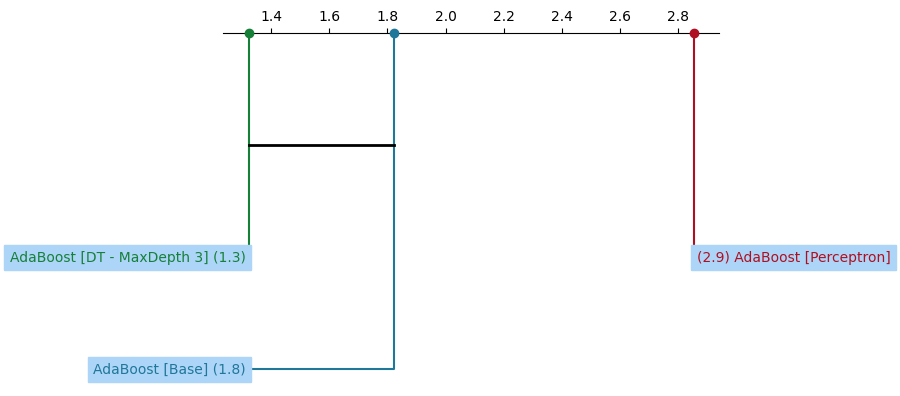

In [19]:
# Plotting tbe Critical Difference Diagram (Recurring to the Nemenyi Test)
weak_learner_modifications_matrix = Weak_Learner_Modifications_Results_df.drop(list(Weak_Learner_Modifications_Results_df.columns[0:4]), axis=1)
colors = {'AdaBoost [Base]':'#1F7799', 'AdaBoost [DT - MaxDepth 3]':'#168039', 'AdaBoost [Perceptron]':'#AF1021'}
Plot_Critial_Difference_Diagram(weak_learner_modifications_matrix, colors)

This Critical Difference Diagram allows for a better understanding of how the Model's Perform against each other.

The AdaBoost with a Decision Tree of Mac Depth 3 and the Standard Version of AdaBoost model perform similarly and significantly better than the one that uses Perceptrons as weak learners. These differences suggest that decision trees are more suited for boosting in the Binary Classification Scenario.

---

### Used a MLP -> Not such a great idea ;/

In [15]:
WEAK_LEARNERS_FILE = './Experimental Results/AdaBoost_Weak_Learner_New_Modifications_Results'
try:
    New_Weak_Learner_Modifications_Results_df = pd.read_csv(WEAK_LEARNERS_FILE + '.csv')
    New_Weak_Learner_Modifications_Results = Load_json_file(WEAK_LEARNERS_FILE + '.json')
except:
    models = [AdaBoost(), AdaBoostMLP()]
    (New_Weak_Learner_Modifications_Results_df,
     New_Weak_Learner_Modifications_Results) = Evaluate_Models(my_tasks, models, ['AdaBoost [Base]', 'AdaBoost [MLP 1 Hidden Layer]'])
    
    New_Weak_Learner_Modifications_Results_df.to_csv(WEAK_LEARNERS_FILE + '.csv', index=False)
    Save_json_file(New_Weak_Learner_Modifications_Results, WEAK_LEARNERS_FILE + '.json')

New_Weak_Learner_Modifications_Results_df

,Dataset,Positive Class (%),Negative Class (%),Majority Class (%),AdaBoost [Base],AdaBoost [MLP 1 Hidden Layer]
0,kr-vs-kp,0.477785,0.522215,0.522215,0.940859,0.922086
1,breast-w,0.349927,0.650073,0.650073,0.963418,0.948787
2,credit-approval,0.546708,0.453292,0.546708,0.872860,0.679930
3,credit-g,0.300000,0.700000,0.700000,0.758000,0.700000
4,diabetes,0.348958,0.651042,0.651042,0.769612,0.640693
5,spambase,0.394045,0.605955,0.605955,0.933927,0.915232
6,tic-tac-toe,0.653445,0.346555,0.653445,0.732755,0.661835
7,electricity,0.575455,0.424545,0.575455,0.770635,0.753642
8,pc4,0.122085,0.877915,0.877915,0.893019,0.877943
9,pc3,0.102367,0.897633,0.897633,0.895072,0.897630


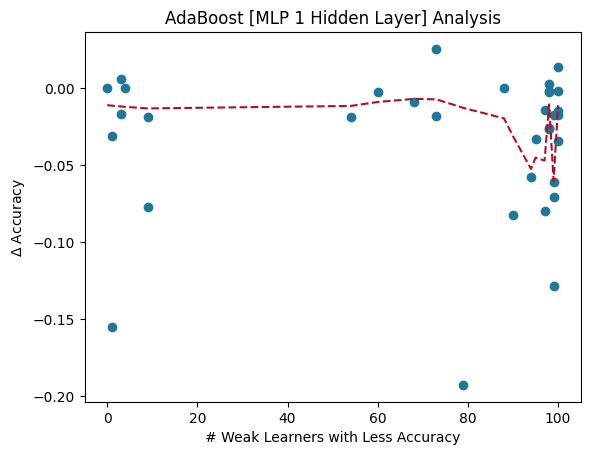

In [16]:
# Managing and PLotting Results
new_results = Manage_Results(New_Weak_Learner_Modifications_Results)
for idx, result in enumerate(new_results):
    Plot_Scatterplot(result, f"{New_Weak_Learner_Modifications_Results_df.columns[idx+5]} Analysis", f"$\Delta$ Accuracy", '# Weak Learners with Less Accuracy')

---

In [17]:
# IDEA: PLOT ROC CURVE & AUC, CONFUSION MATRIX.
# LATER: 
# -> ADD A PAIR PLOT TO COMPARE THE DIFFERENCES BETWEEN BOTH ALGORITHMS (ORIGINAL AND MODIFIED)
# -> ADD A CRITIAL DIFERENCE REGION

---

---
<div align="center">
    
## Tests [REMOVE LATER]
</div>

In [18]:
# Generate classification dataset
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Fit model
ab = AdaBoost()
# ab = AdaBoost(loss_function='logistic')
# ab = AdaBoost(loss_function='hinge')
# ab = AdaBoost(loss_function='squared')

ab.fit(X_train, y_train, M=400)

Plot_ROC_Curve(ab, X_test, y_test)
# Display_Confusion_Matrix(ab, X_test, y_test, np.unique(y))

NameError: name 'AdaBoost_LogisticLoss' is not defined

In [ ]:
# Weak Learners Statistics
Plot_Model_Stats(ab, X_test, y_test)

In [22]:
models = [AdaBoost(), AdaBoost_Outliers()]
(df,results) = Evaluate_Models(my_tasks, models, ['AdaBoost [Base]', 'AdaBoost [Handle Outliers]'])
df

,Dataset,Positive Class (%),Negative Class (%),Majority Class (%),AdaBoost [Base],AdaBoost [Handle Outliers]
0,kr-vs-kp,0.477785,0.522215,0.522215,0.940859,0.522208


<div align="center">

***
## Bibliographic References
***
</div>

1. Cano. Alvaro (Towards Data Science, 2021). __*AdaBoost from Scratch*__. Available [here](https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50)
2. Geeks For Geeks (2023). __*Boosting in Machine Learning | Boosting and AdaBoost*__. Available [here](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)
3. Geeks For Geeks (2024). __*Implementing the AdaBoost Algorithm from Scratch*__. Available [here](https://www.geeksforgeeks.org/implementing-the-adaboost-algorithm-from-scratch/)

___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@up.pt`